In [1]:
import sys
import pathlib
sys.path.insert(0, str(pathlib.Path("").resolve().parent)) #.. this has to be the folder reCNN_visual_prosthesis
import wandb
import glob
import pytorch_lightning as pl
from models import reCNN_bottleneck_CyclicGauss3d
import matplotlib.pyplot as plt
import numpy as np
import pickle
from experiments.utils import pickle_read, download_model, get_neuron_estimates, reconstruct_orientation_maps, visualize_preferred_orientations, rotate_and_compute_distances, circular_distance

In [2]:
save = True

plt.rcParams.update({'font.size': 12})
factor = 5.5
img_path = "img/"

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: csng-cuni (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Global seed set to 42
/opt/conda/lib/python3.8/site-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")
/opt/conda/lib/python3.8/site-packages/neuralpredictors/layers/cores/conv2d.py:128: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)


Model from ./artifacts/model-hl2gbqtm:v0/model.ckpt loaded!
Reconstructed orientation maps are saved in img/reconstructed_orientation_map_lurz.fig


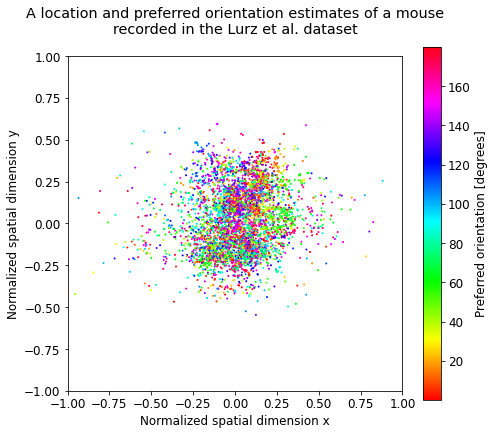

saved


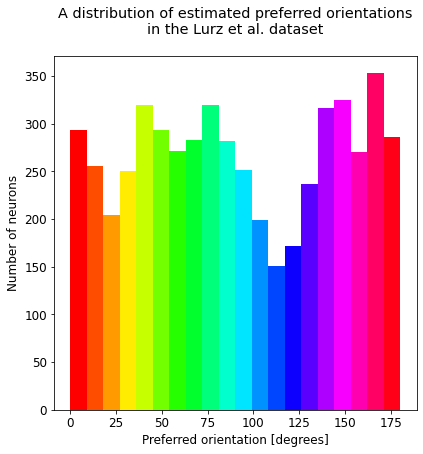

<Figure size 432x288 with 0 Axes>

In [3]:
############################## ON LURZ'S DATASET ###############################

m = download_model(artifact_name="csng-cuni/reCNN_visual_prosthesis/model-hl2gbqtm:v0")

x, y, ori = get_neuron_estimates(m)

# convert orientations to degrees
ori = [180*e for e in ori]

f, ax = plt.subplots()
reconstruct_orientation_maps(x, y, ori, f, ax, save, 12, 1, 1, img_path, "_lurz")
visualize_preferred_orientations(x, y, ori, f, ax, save, 12, 1, 1, img_path, "_lurz")

In [4]:
############################ ON ANTOLIK'S DATASET ##############################

m = download_model(artifact_name="csng-cuni/reCNN_visual_prosthesis/model-abwwf3vs:v0")

x, y, ori = get_neuron_estimates(m, factor)

wandb: wandb version 0.13.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Global seed set to 42


Model from ./artifacts/model-abwwf3vs:v0/model.ckpt loaded!


/opt/conda/lib/python3.8/site-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")
/opt/conda/lib/python3.8/site-packages/neuralpredictors/layers/cores/conv2d.py:128: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)


The average distance error in x is 0.06334875085626564
The average distance error in y is 0.06481617537978818
The average distance error is 0.10076687909280775
saved


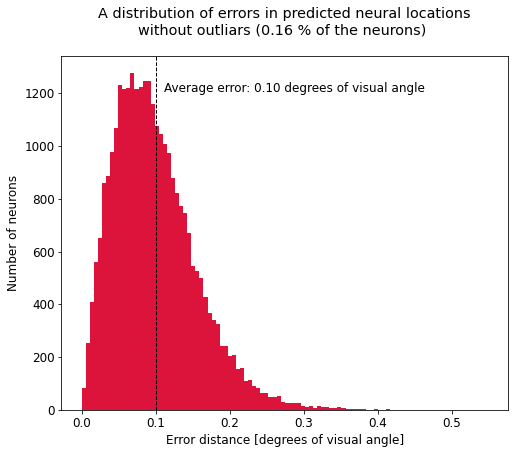

<Figure size 432x288 with 0 Axes>

In [5]:
#####################################################################################
################################## Position errors ##################################
#####################################################################################
# get the target values (values from the Antolik's computational model)
pos_dict = pickle_read("data/antolik/position_dictionary.pickle")
target_positions = np.concatenate([pos_dict['V1_Exc_L2/3'].T, pos_dict['V1_Inh_L2/3'].T])
o_dict = pickle_read("data/antolik/oris.pickle")
target_ori = np.concatenate([np.array(o_dict['V1_Exc_L2/3']), np.array(o_dict['V1_Inh_L2/3'])])

# measure the errors in positions 
s_x = np.zeros((30000))
s_y = np.zeros((30000))
for i in range(30000):
    s_x[i] = abs(x[i] - target_positions[i][0])
    s_y[i] = abs(y[i] + target_positions[i][1]) # it is upside down

avg_x = np.sum(s_x)/30000
avg_y = np.sum(s_y)/30000

distances = np.sqrt(s_x**2 + s_y**2)

print(f"The average distance error in x is {avg_x}")
print(f"The average distance error in y is {avg_y}")
print(f"The average distance error is {np.sum(distances)/30000}")

avg_error = np.mean(distances)
distances = [x for x in distances if x < 0.1 * factor] # delete outliers

# and finally plot the distribution of distance errors
plt.gcf().set_size_inches(8, 6.5)
plt.hist(distances, bins=100, color="crimson")
plt.axvline(avg_error, color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(avg_error*1.1, max_ylim*0.9, 'Average error: {:.2f} degrees of visual angle'.format(avg_error))
plt.title("A distribution of errors in predicted neural locations\nwithout outliars ({:.2f} % of the neurons) \n".format((1 - len(distances)/30000) * 100))
plt.xlabel("Error distance [degrees of visual angle]")
plt.ylabel("Number of neurons")
if save:
    plt.savefig(img_path + "distribution_of_distances_errors", dpi = 300)
    print("saved")
plt.show()
plt.clf()

Average orientation error:
15.927600099075411
Shift:
87.42857142857143
Reconstructed orientation maps are saved in img/reconstructed_orientation_map_antolik.fig


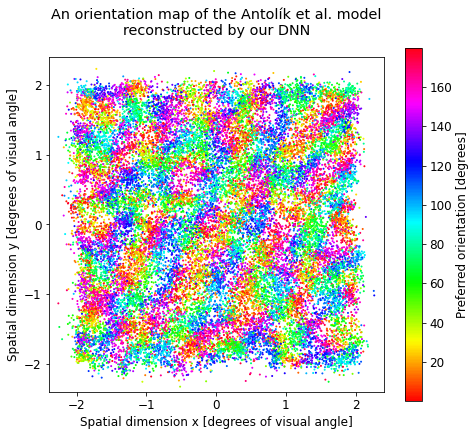

saved


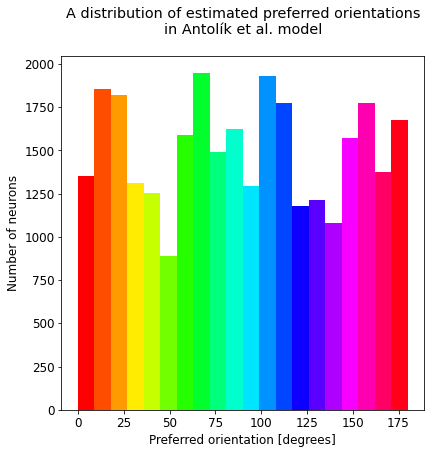

Reconstructed orientation maps are saved in img/true_orientation_map_of_antolik_model.fig


<Figure size 432x288 with 0 Axes>

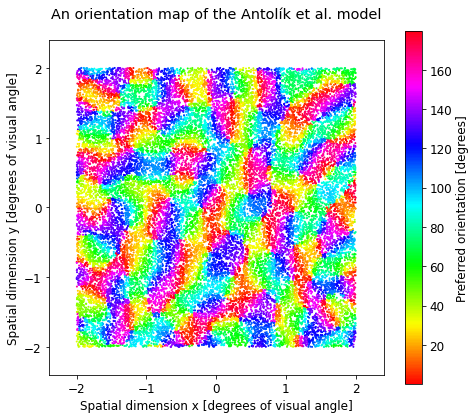

saved


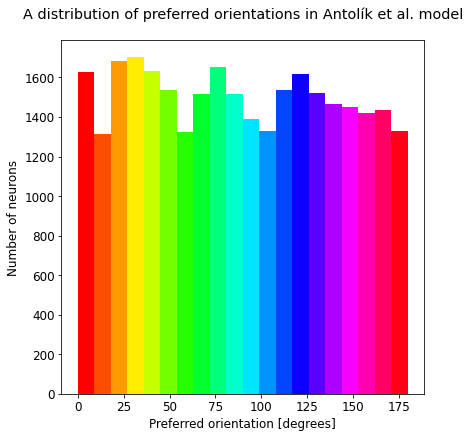

<Figure size 432x288 with 0 Axes>

In [6]:
#####################################################################################
############################### Orientation errors ##################################
#####################################################################################

predicted_ori = np.array(ori)  # [0, 1]
predicted_ori = 180 * predicted_ori # [0, 180]
target_ori = 180 * target_ori / np.pi # from [0, pi] to [0, 180]

result = rotate_and_compute_distances(predicted_ori, target_ori, period=180, n_rot=36)


f, ax = plt.subplots()

print("Average orientation error:")
print(result[0][np.argmin(result[0])])

print("Shift:")
print(result[1][np.argmin(result[0])])
shift = result[1][np.argmin(result[0])]

distances = circular_distance(((predicted_ori + shift) % 180), target_ori, 180) 

# we align the predicted orientations with the ground truth rotations (to have the same shift)
predicted_ori_aligned = (predicted_ori + shift) % 180 
reconstruct_orientation_maps(x, y, predicted_ori_aligned, f, ax, save, 12, 2.4, 2.4, img_path, "_antolik")
visualize_preferred_orientations(x, y, predicted_ori_aligned, f, ax, save, 12, 2.4, 2.4, img_path, "_antolik")

x = target_positions[:, 0]
y = target_positions[:, 1]
y = -y # as the y coordinate is upside down

f, ax = plt.subplots()
reconstruct_orientation_maps(x, y, target_ori, f, ax, save, 12, 2.4, 2.4, img_path, "_truth")
visualize_preferred_orientations(x, y, target_ori, f, ax, save, 12, 2.4, 2.4, img_path, "_truth")



saved


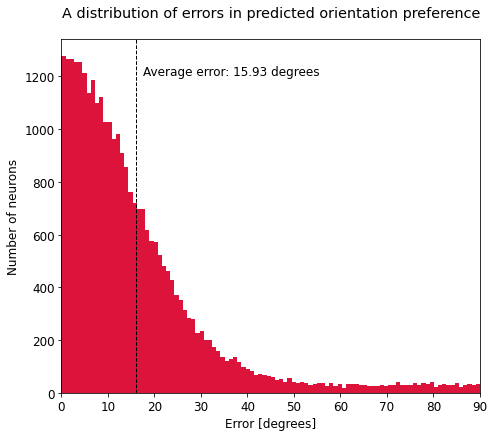

<Figure size 432x288 with 0 Axes>

In [7]:
# visualize the distribution of orientation errors
avg_error = np.mean(distances)
plt.gcf().set_size_inches(7.5, 6.5)
plt.hist(distances, bins=100, color="crimson")
plt.axvline(avg_error, color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(avg_error*1.1, max_ylim*0.9, 'Average error: {:.2f} degrees'.format(avg_error))
plt.xlim(0, 90)
plt.title("A distribution of errors in predicted orientation preference\n")
plt.xlabel("Error [degrees]")
plt.ylabel("Number of neurons")
if save:
    plt.savefig(img_path + "distribution_of_orientation_errors", dpi = 300)
    print("saved")
plt.show()
plt.clf()